In [1]:
import time
import os
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sentence_transformers.util import cos_sim
import sys
import key_words
from IPython.display import clear_output

import pickle
def save_obj(obj:object,name:str):
    ext = '.pickle'
    with open(name + ext, 'wb') as handle:
        pickle.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_obj(name:str)->object:
    ext = '.pickle'
    with open(name + ext, 'rb') as handle:
        return pickle.load(handle)

In [2]:
train_path = "data/train_phase1.tsv"
df = pd.read_csv(train_path, sep="\t")

In [9]:
def maximal_marginal_relevance(doc_embedding: np.ndarray,
        word_embeddings: np.ndarray,
        words,
        top_n = 5,
        diversity = 0.8):
    """
    Maximal Marginal Relevance algorithm for keyword extraction
    * from KeyBERT repository on github

    Args:
        doc_embedding (numpy.ndarray): embedding of shape (1, 768)
        word_embeddings (numpy.ndarray): embedding of shape (N, 768)
        words (List[str]): list of words
        top_n (Optional[int]): number of top words to extract
        diversity (Optional[float]): diversity of top words to extract

    Returns:
        List[Tuple[str, float]]: list of top_n words with their scores
    """
    # make sure 2d array
    if doc_embedding.ndim == 1:
        doc_embedding = doc_embedding.reshape(1, -1)

    # Extract similarity within words, and between words and the document

    word_doc_similarity = np.array(cos_sim(word_embeddings, doc_embedding)).clip(-1, 1).round(6)
    word_similarity = np.array(cos_sim(word_embeddings, word_embeddings)).clip(-1, 1).round(6)

    # Initialize candidates and already choose best keyword/keyphras
    keywords_idx = [np.argmax(word_doc_similarity)]
    candidates_idx = [i for i in range(len(words)) if i != keywords_idx[0]]

    for _ in range(top_n - 1):
        # Extract similarities within candidates and
        # between candidates and selected keywords/phrases
        candidate_similarities = word_doc_similarity[candidates_idx, :]
        target_similarities = np.max(word_similarity[candidates_idx][:, keywords_idx], axis=1)

        # Calculate maximal_marginal_relevance
        mmr = (1-diversity) * candidate_similarities -\
            diversity * target_similarities.reshape(-1, 1)
        # if return mmr is empty
        if mmr.size == 0:
            continue
        mmr = candidates_idx[np.argmax(mmr)]

        # Update keywords & candidates
        keywords_idx.append(mmr)
        candidates_idx.remove(mmr)

    return [words[idx] for idx in keywords_idx]

def emb_keywords(keywords):
    # x = np.array(list(map(lambda k: np.array(list(map(lambda x: BERT.model.encode(str(x)), k))),keywords)))
    x = np.array(list(map(lambda k: np.array(list(map(lambda x: get_words_emb(str(x)), k))),keywords)))
    if x.ndim == 3:
        x = x.reshape(max(x.shape[1],x.shape[0]),x.shape[2])
    return x

def get_candidates(n_grams, doc):
    x = list(map(lambda gram :
        key_words.candidates_tokens(str(doc), n_gram_range=gram)
        , n_grams))
    return x

def match_keywords(
    keywords_emb:list[np.ndarray],
    candidates_emb : list[np.ndarray],
    thershold: float)\
        -> float:
    """
    match keywords with candidates in a document

    Args:
        keywords_emb (List[np.ndarray]): list of keywords embeddings
        candidates_emb (List[np.ndarray]): list of document's candidates embeddings
        thershold (float): threshold

    Returns:
        float: score
    
    example:
        >>> match_keywords(keywords_emb, candidates_emb, thershold=0.5)
        >>> 0.8
    """
    similarities = list(map(lambda cand:
                    cos_sim(np.array(keywords_emb), cand.reshape(cand.shape[0],cand.shape[1])).__array__().max(axis=1).round(6).clip(-1, 1),
                    candidates_emb))
    return similarities

def para_keywords_pipeline_output_dict(keywords,docs,n_gram_list,batch = 50):

    def check_n_gram_dict(n_grams, doc, ind):
        def fn(n_gram):
            x = n_gram_dict[ind].get(n_gram)
            if x is None:
                x =  get_candidates([n_gram], doc)
                n_gram_dict[ind][n_gram] = x
                return x
            else:
                return x
        return list(map(fn, n_grams))

    n_docs = len(docs)
    if n_docs < batch:
        batch = n_docs
    
    n_gram_dict = {ind: {n_gram: None for n_gram in set([item for sublist in n_gram_list for item in sublist])} for ind ,doc in enumerate(docs)}

    n_grams_list = []
    students_candidates_list = []
    keywords_embeddings_list = []
    students_candidates_emb_list = []
    times = []

    # all model answers
    for ind, ans in enumerate(keywords):
        print("model answer",ind)
        t1 = time.perf_counter()
        students_n_grams = key_words.get_n_grams(ans)
        keywords_embeddings =  list(map(model.encode, ans))

        students_candidates_list_s = []
        students_candidates_emb_list_s = []
        # do in batches
        for i in range(0,n_docs,batch):
            students_candidates = list(map(lambda doc:
                            check_n_gram_dict(students_n_grams, doc[1], i+doc[0]),
                            enumerate(docs[i:i+batch])))
            students_candidates_emb =  list(map( lambda st: list(map( emb_keywords ,st)), students_candidates))
            # students_candidates_emb =  list(map(emb_d, students_candidates))
            students_candidates_list_s.extend(students_candidates)
            students_candidates_emb_list_s.extend(students_candidates_emb)

        if n_docs % batch != 0 and n_docs > batch:
            students_candidates = list(map(lambda doc:
                            check_n_gram_dict(students_n_grams, doc[1], i+doc[0]),
                            enumerate(docs[i+batch:])))
            students_candidates_emb =  list(map( lambda st: list(map( emb_keywords ,st)), students_candidates))

            students_candidates_list_s.extend(students_candidates)
            students_candidates_emb_list_s.extend(students_candidates_emb)

        n_grams_list.append(students_n_grams)
        keywords_embeddings_list.append(keywords_embeddings)
        students_candidates_list.append(students_candidates_list_s)
        students_candidates_emb_list.append(students_candidates_emb_list_s)
        times.append(time.perf_counter() - t1)
    return {
        "n_gram_dict": n_gram_dict,
        "n_grams_list": n_grams_list,
        "students_candidates_list": students_candidates_list,
        "keywords_embeddings_list": keywords_embeddings_list,
        "students_candidates_emb_list": students_candidates_emb_list,
        "times": times
    }

def get_words_emb(word):
    if word in words_emb_dict:
        return words_emb_dict[word]
    else:
        words_emb_dict[word] = model.encode(word)
        return words_emb_dict[word]

def grading(keywords_embeddings_list,students_candidates_emb_list,thershold=0.5):
    """
    Args:
        keywords_embeddings_list: list of list of list of embeddings
        students_candidates_emb_list: list of list of list of embeddings
        thershold: thershold for the similarity
    Returns:
        a list of list of list of grades
    """
    grades = []
    for i in range(len(keywords_embeddings_list)):
        # for j in range(len(keywords_embeddings_list[i])):
        #     grades.append(key_words.match_keywords(keywords_embeddings_list[i][j],
        #                                     students_candidates_emb_list[i][j],
        #                                     thershold))
        
        # map(lambda j: grades.append(key_words.match_keywords(keywords_embeddings_list[i][j],)))
        grades.append(np.array(list(map(lambda st_cand:
                match_keywords(keywords_embeddings_list[i], st_cand,
                thershold=thershold),
                students_candidates_emb_list[i]
                ))))
    grades = np.array(list(map(lambda sim: (sim.__array__().max(axis=1) >thershold).sum(axis=1)/float(sim.shape[-1]) , grades)))
    return grades

In [10]:
words_emb_dict = {}

In [22]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")

In [4]:
ess_1_model_answers = load_obj('data/essaySet_1_model_answers')

In [11]:
top_n_l = [7]*10
diversity_l = [0.6,0.6, 0.7,0.7,0.7,0.7,0.6,0.7,0.7,0.7]
ngram_range_l = [(2,2),(2,2),(2,3),(2,3),(2,3),(2,3),(2,2),(2,3),(2,3),(2,3)]

In [15]:
model.encode(ess_1_model_answers).shape

(22, 384)

In [16]:
for essay in range(0,1):
    # get top_n, diversity, ngram_range
    print("essayset",essay+1)
    
    model_candidates = list(map(lambda ans: key_words.candidates_tokens(ans,n_gram_range=ngram_range_l[essay+1]),ess_1_model_answers))
    model_candidate_emb = list(map(lambda cand:model.encode(cand),model_candidates))
    keywords = list(map(lambda x: maximal_marginal_relevance(
        x[0].reshape(1, -1),x[1],x[2],top_n=top_n_l[essay+1],diversity=diversity_l[essay+1]),
        zip(model.encode(ess_1_model_answers),
        model_candidate_emb,model_candidates)))
    students_n_grams = list(map(lambda keyword: sorted(key_words.get_n_grams(keyword)),keywords))

    docs = df.query(f'EssaySet == {essay+1}')["EssayText"].values.tolist()

    dd = para_keywords_pipeline_output_dict(keywords,docs,students_n_grams,batch=10)
    save_obj(dd,f'data/results/new_keywords_res_essay_{essay+1}')

    del dd

essayset 1
model answer 0
model answer 1
model answer 2
model answer 3
model answer 4
model answer 5
model answer 6
model answer 7
model answer 8
model answer 9
model answer 10
model answer 11
model answer 12
model answer 13
model answer 14
model answer 15
model answer 16
model answer 17
model answer 18
model answer 19
model answer 20
model answer 21


>roberta model toke 800s == 12 min

>this toke only 378s == 6.3 min

In [18]:
dd = load_obj(f'data/results/new_keywords_res_essay_{1}')

## tune threshold

In [20]:
from IPython.display import clear_output

df_dict ={}

for i in range(1,11):
    df_dict['ess_'+str(i)+'_keywords'] = pd.DataFrame(df[df['EssaySet'] == i]['score_gn_1'])
    # remove index
    df_dict['ess_'+str(i)+'_keywords'].reset_index(drop=True, inplace=True)

In [21]:
# for essay in range(1,11)[:2]:
for essay in range(1,2):
    print("Loading essay",essay,"...")
    # grid search for the best threshold
    thresholds = np.arange(0.2, 0.95, 0.03).round(3)
    for threshold in thresholds:
        print(f"Grading essay {essay} threshold {threshold} ...")
        x = grading(dd['keywords_embeddings_list'],dd['students_candidates_emb_list'],threshold)
        df_dict[f'ess_{essay}_keywords'][f'keys_score_{threshold}'] = np.median(x ,axis=0)
        clear_output()
print("Done!")

Done!


In [23]:
# mean square error between the grades and the score_gn_1
mse_mx = []
mse_md = []

thresholds_best = []
for essay in range(1,2):
    thresholds = np.arange(0.2, 0.95, 0.03).round(3)
    for threshold in thresholds:
        mse_mx.append(np.max((df_dict[f'ess_{essay}_keywords'][f'keys_score_{threshold}'] - df_dict[f'ess_{essay}_keywords']['score_gn_1'])**2))
        mse_md.append(np.median((df_dict[f'ess_{essay}_keywords'][f'keys_score_{threshold}'] - df_dict[f'ess_{essay}_keywords']['score_gn_1'])**2))

In [24]:
thresholds[np.argsort(mse_mx)[:3]], thresholds[np.argsort(mse_md)[:3]]

(array([0.56, 0.5 , 0.53]), array([0.47, 0.5 , 0.53]))

In [10]:
docs = df.query(f'EssaySet == {1}')["EssayText"].values.tolist()

In [11]:
keywords_threshold = 0.56
siamese_scores = cos_sim(model.encode(ess_1_model_answers),model.encode(docs))

In [5]:
ner_scores = load_obj("data/results/ner_res")
special_keywords_res = load_obj("data/results/special_keywords_res")

In [29]:
kwrds_res = grading(dd['keywords_embeddings_list'],dd['students_candidates_emb_list'],keywords_threshold)

In [34]:
kwrds_res = df_dict[f'ess_{1}_keywords'][f'keys_score_{0.56}']

In [35]:
n_df = pd.concat([pd.DataFrame(kwrds_res), pd.DataFrame(siamese_scores[0]), pd.DataFrame(ner_scores[0]),
    pd.DataFrame(special_keywords_res['ess_1_model_answers']),
    pd.DataFrame(df[df['EssaySet'] == 1]['score_gn_1'])],axis=1)
n_df.columns = ['keywords_score', 'siamese_score', 'ner_score', 'special_keywords_score','label']

# train

In [12]:
n_df = pd.concat([ pd.DataFrame(siamese_scores[0]), pd.DataFrame(ner_scores[0]),
    pd.DataFrame(df[df['EssaySet'] == 1]['score_gn_1'])],axis=1)
n_df.columns = [ 'siamese_score', 'ner_score', 'label']

In [17]:
# train a regression model
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# train the model
# X = n_df[['keywords_score', 'siamese_score', 'ner_score', 'special_keywords_score']]
X = n_df[[ 'siamese_score',]]
y = n_df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
models_dict = {
    'l_rg': LinearRegression(),
    'l_svr': SVR(),
    # 'l_knr': KNeighborsRegressor(),
    'l_dt': DecisionTreeRegressor(),
    'l_rf': RandomForestRegressor(),
    'l_gb': GradientBoostingRegressor(),
    'l_xgb': XGBRegressor(),
    'l_lgb': LGBMRegressor(),
    'l_cat': CatBoostRegressor(),
    'l_mlp': MLPRegressor(),
    # 'l_ada': AdaBoostRegressor(),
    'l_gpr': GaussianProcessRegressor(),
}

In [19]:
for model_name, mod in models_dict.items():
    mod.fit(X_train, y_train)
clear_output()

# only similarities

In [20]:
for model_name, mod in models_dict.items():
    print(f"{model_name} MSE:", mean_squared_error(y_test, mod.predict(X_test)))
    print(f"{model_name} R2:", r2_score(y_test, mod.predict(X_test)))

l_rg MSE: 0.08016690821143074
l_rg R2: 0.32072592695361946
l_svr MSE: 0.07880238955245789
l_svr R2: 0.33228783158369113
l_dt MSE: 0.1581334621635266
l_dt R2: -0.3399039993590314
l_rf MSE: 0.11790648848502693
l_rf R2: 0.0009491140585047297
l_gb MSE: 0.07998402738679085
l_gb R2: 0.3222755214859119
l_xgb MSE: 0.10043182031052571
l_xgb R2: 0.14901630650556097
l_lgb MSE: 0.08407283654604997
l_lgb R2: 0.2876300285576556
l_cat MSE: 0.08542547855118882
l_cat R2: 0.2761687577577262
l_mlp MSE: 0.07770963235887499
l_mlp R2: 0.3415470339939689
l_gpr MSE: 0.07657667269410921
l_gpr R2: 0.35114688190194865


# similarities and ner

In [16]:
for model_name, mod in models_dict.items():
    print(f"{model_name} MSE:", mean_squared_error(y_test, mod.predict(X_test)))
    print(f"{model_name} R2:", r2_score(y_test, mod.predict(X_test)))

l_rg MSE: 0.07906753196393922
l_rg R2: 0.33004121424740496
l_svr MSE: 0.07783589811632013
l_svr R2: 0.3404771529512842
l_dt MSE: 0.1488011623301346
l_dt R2: -0.2608291109774141
l_rf MSE: 0.10701452257120235
l_rf R2: 0.0932394395161481
l_gb MSE: 0.07989692835774731
l_gb R2: 0.32301353313606496
l_xgb MSE: 0.09899255145954848
l_xgb R2: 0.16121158803037205
l_lgb MSE: 0.0846255036987984
l_lgb R2: 0.28294714286002753
l_cat MSE: 0.0835709550707935
l_cat R2: 0.2918825946287441
l_mlp MSE: 0.07818709635111137
l_mlp R2: 0.33750136330545966
l_gpr MSE: 0.07646990611101517
l_gpr R2: 0.35205154160982033


# all

In [45]:
for model_name, mod in models_dict.items():
    print(f"{model_name} MSE:", mean_squared_error(y_test, mod.predict(X_test)))
    print(f"{model_name} R2:", r2_score(y_test, mod.predict(X_test)))

l_rg MSE: 0.0651946784016764
l_rg R2: 0.44758933920640886
l_svr MSE: 0.06445518189885016
l_svr R2: 0.4538552762705341
l_dt MSE: 0.13787641007222645
l_dt R2: -0.16826097870418044
l_rf MSE: 0.08172926665999261
l_rf R2: 0.30748767677545275
l_gb MSE: 0.06754066502702874
l_gb R2: 0.42771121335786577
l_xgb MSE: 0.08204282298646963
l_xgb R2: 0.30483083634381525
l_lgb MSE: 0.07622755593069137
l_lgb R2: 0.35410503472518284
l_cat MSE: 0.0725144281058606
l_cat R2: 0.38556728663918405
l_mlp MSE: 0.06503687451894977
l_mlp R2: 0.4489264505975523
l_gpr MSE: 0.1184098395065301
l_gpr R2: -0.0033159038419829923


# essay 3

In [33]:
ess_3_model_answers = load_obj('data/essaySet_3_model_answers')
docs_3 = df.query(f'EssaySet == {3}')["EssayText"].values.tolist()
siamese_scores_3 = cos_sim(model.encode(ess_3_model_answers),model.encode(docs_3))

In [78]:
np.vstack((siamese_scores_3.__array__().max(axis=0).reshape(-1,),
    df[df['EssaySet'] == 3]['score_gn_1'].values.reshape(-1,))).shape

(2, 1891)

In [87]:
n_df = pd.DataFrame(np.vstack((np.median(siamese_scores_3.__array__(),axis=0).reshape(-1,),
    df[df['EssaySet'] == 3]['score_gn_1'].values.reshape(-1,))).T,
    columns=['siamese_score', 'label'])

In [88]:
X = n_df[[ 'siamese_score',]]
y = n_df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [91]:
for model_name, mod in models_dict.items():
    mod.fit(X_train, y_train)
    clear_output()

In [92]:
for model_name, mod in models_dict.items():
    print(f"{model_name} MSE:", mean_squared_error(y_test, mod.predict(X_test)))
    print(f"{model_name} R2:", r2_score(y_test, mod.predict(X_test)))

l_rg MSE: 0.10884380458524429
l_rg R2: 0.006063815867958677
l_svr MSE: 0.11170521242003192
l_svr R2: -0.020065891701450456
l_dt MSE: 0.1920889564495022
l_dt R2: -0.7541114546193219
l_rf MSE: 0.1447664103066091
l_rf R2: -0.32197302362720914
l_gb MSE: 0.10723206960803724
l_gb R2: 0.020781802979689012
l_xgb MSE: 0.12429180899824992
l_xgb R2: -0.13500374987201447
l_lgb MSE: 0.10869216422323673
l_lgb R2: 0.007448560211915867
l_cat MSE: 0.11236932563779878
l_cat R2: -0.026130418387320553
l_mlp MSE: 0.10895347903859515
l_mlp R2: 0.00506229439344108
l_gpr MSE: 0.10960023097986328
l_gpr R2: -0.0008436931731785613


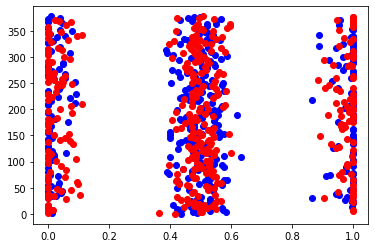

In [93]:
plt.scatter(models_dict['l_dt'].predict(X_test),np.arange(0,len(y_test)), color='blue')
plt.scatter(y_test ,np.arange(0,len(y_test)), color='red');